# Overpass Turbo Query for NYC area power features

In [12]:
"""[out:json][timeout:25];
(
  // Nodes, ways, and relations with the "power" key
  node["power"](40.4774,-74.2591,40.9176,-73.7004); // Bounding box for NYC
  way["power"](40.4774,-74.2591,40.9176,-73.7004);
  relation["power"](40.4774,-74.2591,40.9176,-73.7004);
);
out body;
>;
out skel qt;"""

'[out:json][timeout:25];\n(\n  // Nodes, ways, and relations with the "power" key\n  node["power"](40.4774,-74.2591,40.9176,-73.7004); // Bounding box for NYC\n  way["power"](40.4774,-74.2591,40.9176,-73.7004);\n  relation["power"](40.4774,-74.2591,40.9176,-73.7004);\n);\nout body;\n>;\nout skel qt;'

In [23]:
import geopandas as gpd
import sys
import pandas as pd
import requests
import osmnx as ox
import networkx as nx
import random
sys.path.append('..')
from security_game.security_game import SecurityGame
from security_game.target import Target
pd.options.display.max_rows = 4000

In [2]:
gdf = gpd.read_file("nyc_power.geojson")

In [97]:
gdf

,id,@id,NY_mta:propcode,access,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,alt_name,...,transformer,type,voltage,voltage:primary,voltage:secondary,website,wikidata,wikipedia,wires,geometry
0,relation/12529566,relation/12529566,None,None,None,None,None,None,None,None,...,None,multipolygon,None,None,None,None,None,None,None,"MULTIPOLYGON (((-73.70169 40.75254, -73.70142 ..."
1,relation/13567034,relation/13567034,None,None,None,None,None,None,None,None,...,None,multipolygon,None,None,None,None,None,None,None,"POLYGON ((-74.16847 40.55964, -74.16846 40.559..."
2,relation/13567035,relation/13567035,None,None,None,None,None,None,None,None,...,None,multipolygon,None,None,None,None,None,None,None,"POLYGON ((-74.16787 40.55971, -74.16785 40.559..."
3,relation/13567036,relation/13567036,None,None,None,None,None,None,None,None,...,None,multipolygon,None,None,None,None,None,None,None,"POLYGON ((-74.16716 40.55987, -74.16707 40.559..."
4,relation/13828177,relation/13828177,None,None,None,None,None,None,None,None,...,None,multipolygon,None,None,None,None,None,None,None,"POLYGON ((-74.16590 40.58492, -74.16571 40.584..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18886,node/12306416887,node/12306416887,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-74.14840 40.80517)
18887,node/12398368569,node/12398368569,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-74.12880 40.60231)
18888,node/12438048445,node/12438048445,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-74.20743 40.64408)
18889,node/12445458899,node/12445458899,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-74.12977 40.60254)


In [3]:
df = gdf[["id","name","operator","power","voltage","substation","transformer","generator:method","circuits","wires","area","man_made","height","location","phases","line_management","line_attachment","devices","emergency","foot","geometry"]]
df = df[~df["generator:method"].str.contains("photovoltaic", na=False)]

In [4]:
df["geometry"][18886].y

40.8051671

In [5]:
df_simple = df[["id","power","geometry"]]

In [98]:
df_simple

,id,power,geometry
0,relation/12529566,substation,"MULTIPOLYGON (((-73.70169 40.75254, -73.70142 ..."
16,relation/14695844,substation,"MULTIPOLYGON (((-73.73504 40.77940, -73.73522 ..."
34,relation/15673095,plant,"MULTIPOLYGON (((-74.02138 40.81467, -74.02032 ..."
35,relation/15673278,plant,"MULTIPOLYGON (((-74.01567 40.81720, -74.01627 ..."
36,relation/15673305,plant,"MULTIPOLYGON (((-74.06624 40.76094, -74.06601 ..."
...,...,...,...
18884,node/12291925216,tower,POINT (-74.12088 40.74419)
18885,node/12306416886,portal,POINT (-74.14885 40.80532)
18886,node/12306416887,portal,POINT (-74.14840 40.80517)
18888,node/12438048445,tower,POINT (-74.20743 40.64408)


In [7]:
df_nodes = df_simple[df_simple["id"].str.contains("node")].reset_index()
df_nodes["x"] = [df_nodes["geometry"][i].x for i in range(len(df_nodes))]
df_nodes["y"] = [df_nodes["geometry"][i].y for i in range(len(df_nodes))]
df_nodes = df_nodes.drop("geometry", axis=1)
df_nodes

,index,id,power,x,y
0,3455,node/302151657,tower,-74.110075,40.783746
1,3456,node/302151663,tower,-74.110214,40.781399
2,3457,node/302151666,tower,-74.110350,40.779066
3,3458,node/302151678,tower,-74.110800,40.776424
4,3459,node/302151680,tower,-74.111350,40.774648
...,...,...,...,...,...
6458,18884,node/12291925216,tower,-74.120884,40.744192
6459,18885,node/12306416886,portal,-74.148851,40.805320
6460,18886,node/12306416887,portal,-74.148403,40.805167
6461,18888,node/12438048445,tower,-74.207428,40.644082


In [8]:
# Define a projected CRS (e.g., UTM Zone 18N for NYC)
projected_crs = "EPSG:32618"  # UTM Zone 18N (suitable for New York)
geographic_crs = "EPSG:4326"  # Standard lat/lon

df_ways = df_simple[df_simple["id"].str.contains("way")].reset_index(drop=True)
df_ways = df_ways.set_geometry("geometry").to_crs(projected_crs)  # Reproject to projected CRS
df_ways["centroid"] = df_ways["geometry"].centroid  # Compute centroid in projected CRS
df_ways = df_ways.set_geometry("centroid").to_crs(geographic_crs)  # Convert back to lat/lon
df_ways["x"] = df_ways["centroid"].x
df_ways["y"] = df_ways["centroid"].y
df_ways = df_ways.drop(columns=["geometry", "centroid"])  # Drop unnecessary columns
df_ways

,id,power,x,y
0,way/39836037,plant,-74.099332,40.737580
1,way/39836038,substation,-74.098425,40.737890
2,way/39836042,plant,-74.120703,40.737708
3,way/54618157,substation,-74.117109,40.760623
4,way/65355276,substation,-74.043273,40.735828
5,way/87821749,substation,-73.705852,40.637159
6,way/89903766,generator,-73.974055,40.582151
7,way/94810815,substation,-74.258239,40.791976
8,way/95199038,substation,-74.257107,40.789950
9,way/95200267,substation,-74.217586,40.867238


In [9]:
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
df_combined

,index,id,power,x,y
0,3455.0,node/302151657,tower,-74.110075,40.783746
1,3456.0,node/302151663,tower,-74.110214,40.781399
2,3457.0,node/302151666,tower,-74.110350,40.779066
3,3458.0,node/302151678,tower,-74.110800,40.776424
4,3459.0,node/302151680,tower,-74.111350,40.774648
...,...,...,...,...,...
8099,NaN,way/1330088551,line,-74.148122,40.805112
8100,NaN,way/1330088552,line,-74.145397,40.804102
8101,NaN,way/1330088553,line,-74.149224,40.805486
8102,NaN,way/1330088554,line,-74.147525,40.804870


# Census Block-level Population Data

In [10]:
# Load the shapefile
# blocks_gdf = gpd.read_file("tl_2020_36_tabblock20.shp")
nj_blocks_gdf = gpd.read_file("tl_2020_34_tabblock20.shp")
# Display the data
print(nj_blocks_gdf.head())

  STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        34        023    001903      2001  340230019032001  Block 2001   
1        34        023    980100      1000  340239801001000  Block 1000   
2        34        023    003001      3019  340230030013019  Block 3019   
3        34        023    009000      1008  340230090001008  Block 1008   
4        34        023    002703      2004  340230027032004  Block 2004   

  MTFCC20 UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040    U  63217        U          S    10132         0  +40.5378349   
1   G5040    U  63217        U          S    10289         0  +40.5173743   
2   G5040    U  63217        U          S     9575         0  +40.5537862   
3   G5040    U  63217        U          S   336508         0  +40.5861400   
4   G5040    U  63217        U          S    31718         0  +40.5777278   

     INTPTLON20  HOUSING20  POP20  \
0  -074.3413930          0      0   
1  -074.3012

In [99]:
nj_blocks_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
0,34,023,001903,2001,340230019032001,Block 2001,G5040,U,63217,U,S,10132,0,+40.5378349,-074.3413930,0,0,"POLYGON ((-74.34374 40.53623, -74.34319 40.536..."
1,34,023,980100,1000,340239801001000,Block 1000,G5040,U,63217,U,S,10289,0,+40.5173743,-074.3012683,0,0,"POLYGON ((-74.30146 40.51789, -74.30129 40.519..."
2,34,023,003001,3019,340230030013019,Block 3019,G5040,U,63217,U,S,9575,0,+40.5537862,-074.2902290,11,36,"POLYGON ((-74.29102 40.55399, -74.29032 40.554..."
3,34,023,009000,1008,340230090001008,Block 1008,G5040,U,63217,U,S,336508,0,+40.5861400,-074.2727224,0,0,"POLYGON ((-74.27796 40.58798, -74.27768 40.587..."
4,34,023,002703,2004,340230027032004,Block 2004,G5040,U,63217,U,S,31718,0,+40.5777278,-074.2832781,35,79,"POLYGON ((-74.28478 40.57684, -74.28334 40.578..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137967,34,019,011204,1039,340190112041039,Block 1039,G5040,R,None,None,S,272134,842,+40.5490524,-074.8429252,23,82,"POLYGON ((-74.84724 40.54881, -74.84711 40.548..."
137968,34,029,733002,1017,340297330021017,Block 1017,G5040,R,None,None,S,3670494,1859,+39.8031100,-074.2899676,0,0,"POLYGON ((-74.30978 39.79392, -74.30945 39.794..."
137969,34,039,039100,1003,340390391001003,Block 1003,G5040,U,63217,U,S,23788,0,+40.6322824,-074.3916120,29,84,"POLYGON ((-74.39327 40.63179, -74.39310 40.631..."
137970,34,037,373600,1041,340373736001041,Block 1041,G5040,R,None,None,S,3514687,134913,+41.0179988,-074.7542236,102,226,"POLYGON ((-74.76817 41.01853, -74.76811 41.018..."


In [11]:
from shapely.geometry import Point

def assign_population(power_df, block_gdf, mode="block", radius=None):
    """
    Assigns population to power features based on Census block data.

    Parameters:
    - power_df: DataFrame with columns ['id', 'x', 'y'] representing power feature locations.
    - block_gdf: GeoDataFrame with block geometries and population data.
    - mode: "block" assigns population of the block containing the feature; "radius" sums population of blocks within radius.
    - radius: Radius in meters for "radius" mode (ignored for "block" mode).

    Returns:
    - A new DataFrame with an added 'population' column.
    """

    # Convert power features into a GeoDataFrame
    power_gdf = gpd.GeoDataFrame(
        power_df,
        geometry=gpd.points_from_xy(power_df.x, power_df.y),
        crs=block_gdf.crs  # Ensure matching coordinate reference system
    )

    if mode == "block":
        # Spatial join to find the containing block
        joined = gpd.sjoin(power_gdf, block_gdf[['POP20', 'geometry']], how="left", predicate="within")
        power_df['population'] = joined['POP20']

    elif mode == "radius":
        if radius is None:
            raise ValueError("Radius must be specified for 'radius' mode.")

        # Convert meters to CRS units (assumes projected CRS, otherwise use geopy or pyproj for accurate conversion)
        power_gdf = power_gdf.to_crs(epsg=3857)  # Convert to meters-based CRS
        block_gdf = block_gdf.to_crs(epsg=3857)

        # Create buffer zones and find intersecting blocks
        power_gdf['buffer'] = power_gdf.geometry.buffer(radius)
        power_df['population'] = power_gdf['buffer'].apply(
            lambda buf: block_gdf[block_gdf.geometry.intersects(buf)]['POP20'].sum()
            if not block_gdf[block_gdf.geometry.intersects(buf)].empty else float('nan')
        )

    else:
        raise ValueError("Invalid mode. Choose 'block' or 'radius'.")

    return power_df[['id', 'x', 'y', 'power', 'population']]

In [12]:
power_df = assign_population(df_combined, nj_blocks_gdf, mode="block", radius=None)

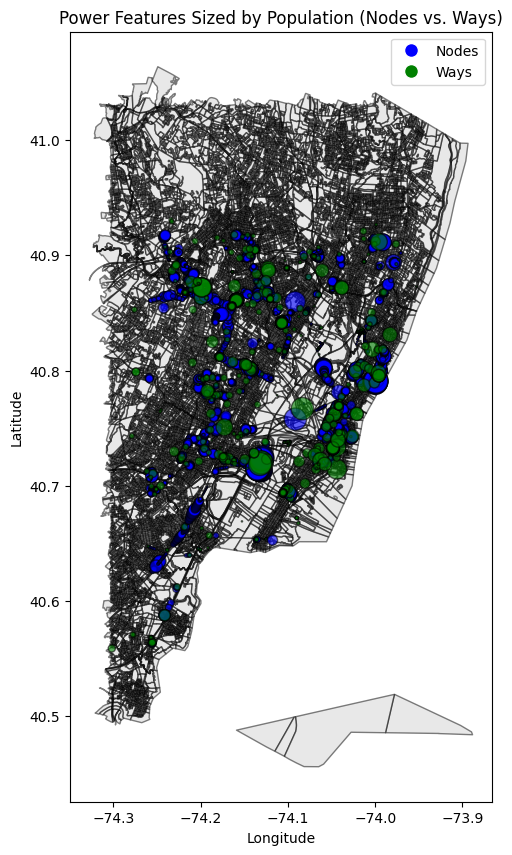

In [13]:
import matplotlib.pyplot as plt

def plot_power_features(power_df, block_gdf):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot blocks as background
    block_gdf.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5)

    # Normalize population for marker size
    max_pop = power_df["population"].max()
    power_df["size"] = (power_df["population"] / max_pop) * 300  # Scale marker size

    # Assign color based on type (node or way)
    power_df["color"] = power_df["id"].apply(lambda x: "blue" if x.startswith("node") else "green")

    # Plot power features with different colors
    scatter = ax.scatter(
        power_df["x"], power_df["y"], 
        s=power_df["size"], c=power_df["color"], 
        alpha=0.6, edgecolors="black"
    )

    # Add legend manually
    legend_labels = {"blue": "Nodes", "green": "Ways"}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color in legend_labels.keys()]
    ax.legend(handles, legend_labels.values(), loc="upper right")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Power Features Sized by Population (Nodes vs. Ways)")
    plt.show()

# Define min/max bounds of power features
minx, miny, maxx, maxy = power_df["x"].min(), power_df["y"].min(), power_df["x"].max(), power_df["y"].max()

# Filter blocks within this bounding box
# nyc_blocks = blocks_gdf.cx[minx:maxx, miny:maxy]
nj_blocks = nj_blocks_gdf.cx[minx:maxx, miny:maxy]

# Call function
plot_power_features(power_df, nj_blocks)

C:\Users\Noah\AppData\Local\Temp\ipykernel_29116\1215836238.py:20: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\Noah\AppData\Local\Temp\ipykernel_29116\1215836238.py:20: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\Noah\AppData\Local\Temp\ipykernel_29116\1215836238.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

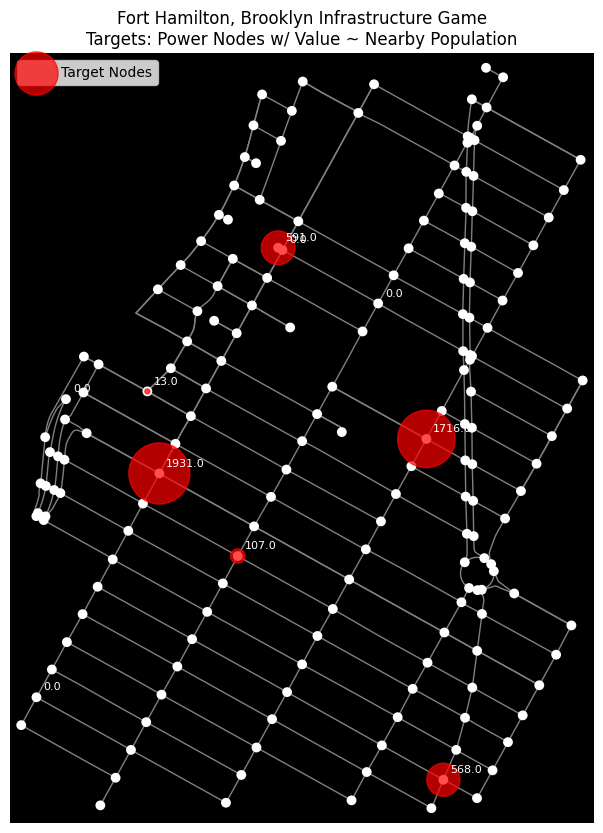

In [79]:
class Target:
    def __init__(self, node, value):
        self.node = node
        self.value = value

def create_security_game_graph(pdf, bbox):
    """
    Creates a security game graph for Manhattan based on city streets and power features.
    
    Parameters:
        power_features_df (pd.DataFrame): DataFrame containing power feature locations and populations.
        bbox (tuple): Bounding box (south, west, north, east) to limit the graph size.
    
    Returns:
        G (networkx.Graph): The street graph with power feature nodes assigned as targets.
        target_nodes (list of Target): List of target nodes with assigned values.
    """
    # Get the graph for Manhattan within the bounding box
    north, south, east, west = bbox
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    G = nx.convert_node_labels_to_integers(G)  # Convert node labels for consistency

    # Get bounding box from the graph
    min_x, min_y, max_x, max_y = (
        min(nx.get_node_attributes(G, "x").values()),
        min(nx.get_node_attributes(G, "y").values()),
        max(nx.get_node_attributes(G, "x").values()),
        max(nx.get_node_attributes(G, "y").values()),
    )

# Filter power_gdf to only include points within this bounding box
    pdf = pdf[
        (pdf["x"] >= min_x) & (pdf["x"] <= max_x) &
        (pdf["y"] >= min_y) & (pdf["y"] <= max_y)
    ]
    
    # Convert power feature locations to geometry
    pdf["geometry"] = pdf.apply(lambda row: Point(row["x"], row["y"]), axis=1)
    power_gdf = gpd.GeoDataFrame(pdf, geometry="geometry", crs="EPSG:4326")
    
    # Get closest nodes for power features
    target_nodes = []
    for _, row in power_gdf.iterrows():
        closest_node = ox.distance.nearest_nodes(G, row["x"], row["y"])
        target_value = row["population"]  # Assign population as target value
        target_nodes.append(Target(closest_node, target_value))
        G.nodes[closest_node]["target"] = True  # Mark node as target
        G.nodes[closest_node]["value"] = target_value
    
    return G, target_nodes

def plot_security_game_graph(G, target_nodes):
    """
    Plots the security game graph, highlighting target nodes.
    
    Parameters:
        G (networkx.Graph): The street graph.
        target_nodes (list of Target): List of target nodes.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("black")
    
    ox.plot_graph(G, ax=ax, node_size=50, edge_color="gray", show=False, close=False)
    
    target_xs, target_ys, sizes = [], [], []
    for target in target_nodes:
        x, y = G.nodes[target.node]['x'], G.nodes[target.node]['y']
        ax.annotate(f"{target.value:.1f}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8, color="white")
        target_xs.append(x)
        target_ys.append(y)
        sizes.append(target.value)  # Scale for visibility
    
    ax.scatter(target_xs, target_ys, s=sizes, c="red", label="Target Nodes", alpha=0.7)
    ax.legend()
    plt.title("Fort Hamilton, Brooklyn Infrastructure Game\nTargets: Power Nodes w/ Value ~ Nearby Population")
    plt.show()

# Example usage:
bbox_fort_hamilton = (40.6320, 40.6200, -74.0250, -74.0501)  # Adjust bounding box as needed
bbox_westside_manhattan = (40.7795, 40.7624, -73.9784, -73.9957)
G, target_nodes = create_security_game_graph(power_df, bbox_westside_manhattan)
plot_security_game_graph(G, target_nodes)

C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\3311046230.py:44: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\3311046230.py:44: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\3311046230.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

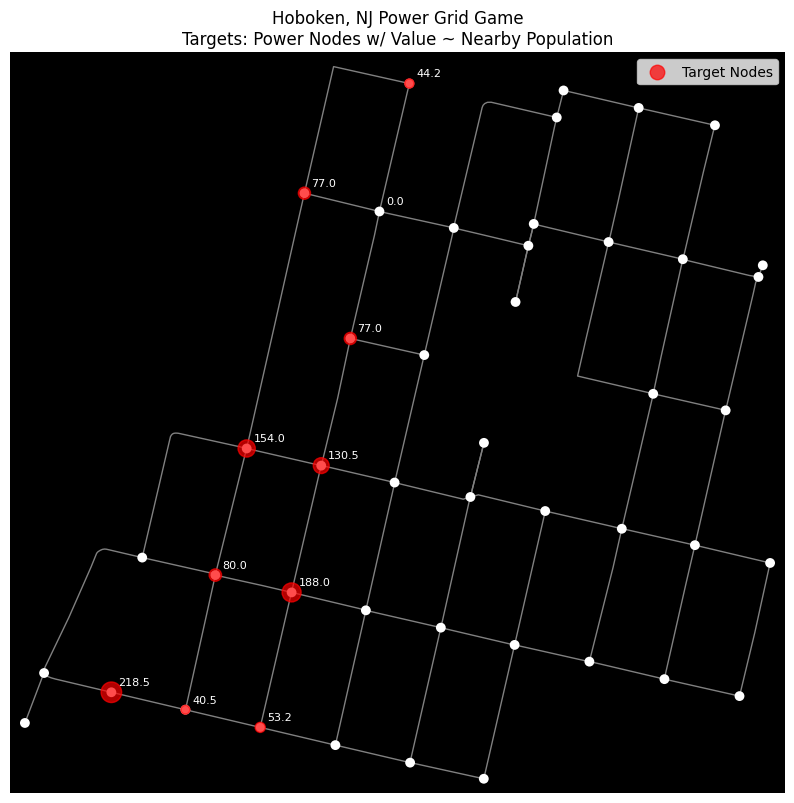

In [22]:
class Target:
    def __init__(self, node, value):
        self.node = node
        self.value = value

# Power feature weights
POWER_WEIGHTS = {
    "plant": 2.0,
    "generator": 1.0,
    "line": 0.5,
    "cable": 0.25,
    "minor_line": 0.1,
    "tower": 0.75,
    "pole": 0.25,
    "substation": 1.0,
    "transformer": 0.5,
    "switchgear": 0.3,
    "busbar": 0.1,
    "bay": 0.1,
    "converter": 0.1,
    "insulator": 0.1,
    "portal": 0.1,
    "connection": 0.1,
    "compensator": 0.3,
    "rectifier": 0.1,
    "inverter": 0.1,
    "storage": 0.05,
}

def create_security_game_graph(pdf, bbox):
    """
    Creates a security game graph for Manhattan based on city streets and power features.
    
    Parameters:
        pdf (pd.DataFrame): DataFrame containing power feature locations, populations, and types.
        bbox (tuple): Bounding box (north, south, east, west) to limit the graph size.
    
    Returns:
        G (networkx.Graph): The street graph with power feature nodes assigned as targets.
        target_nodes (list of Target): List of target nodes with assigned values.
    """
    # Get the graph for Manhattan within the bounding box
    north, south, east, west = bbox
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
    G = nx.convert_node_labels_to_integers(G)  # Convert node labels for consistency

    # Get bounding box from the graph
    min_x, min_y, max_x, max_y = (
        min(nx.get_node_attributes(G, "x").values()),
        min(nx.get_node_attributes(G, "y").values()),
        max(nx.get_node_attributes(G, "x").values()),
        max(nx.get_node_attributes(G, "y").values()),
    )

    # Filter power_df to only include points within this bounding box
    pdf = pdf[
        (pdf["x"] >= min_x) & (pdf["x"] <= max_x) &
        (pdf["y"] >= min_y) & (pdf["y"] <= max_y)
    ]

    # Convert power feature locations to geometry
    pdf["geometry"] = pdf.apply(lambda row: Point(row["x"], row["y"]), axis=1)
    power_gdf = gpd.GeoDataFrame(pdf, geometry="geometry", crs="EPSG:4326")


    # Get closest nodes for power features
    target_nodes = {}
    for _, row in power_gdf.iterrows():
        closest_node = ox.distance.nearest_nodes(G, row["x"], row["y"])
        target_value = row["population"] * POWER_WEIGHTS.get(row["power"], 1.0)  # Apply weight
    
        if closest_node in target_nodes:
            target_nodes[closest_node].value += target_value  # Add to existing value
        else:
            target_nodes[closest_node] = Target(closest_node, target_value)
    
        G.nodes[closest_node]["target"] = True  
        G.nodes[closest_node]["value"] = target_nodes[closest_node].value  # Store updated value
    
    # Convert dictionary to list
    target_nodes = list(target_nodes.values())
    
    return G, target_nodes

def plot_security_game_graph(G, target_nodes):
    """
    Plots the security game graph, highlighting target nodes.
    
    Parameters:
        G (networkx.Graph): The street graph.
        target_nodes (list of Target): List of target nodes.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("black")
    
    ox.plot_graph(G, ax=ax, node_size=50, edge_color="gray", show=False, close=False)

    target_xs, target_ys, sizes = [], [], []
    for target in target_nodes:
        x, y = G.nodes[target.node]["x"], G.nodes[target.node]["y"]
        ax.annotate(f"{target.value:.1f}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8, color="white")
        target_xs.append(x)
        target_ys.append(y)
        sizes.append(target.value)  # Scale for visibility

    ax.scatter(target_xs, target_ys, s=sizes, c="red", label="Target Nodes", alpha=0.7)
    ax.legend()
    plt.title("Hoboken, NJ Power Grid Game\nTargets: Power Nodes w/ Value ~ Nearby Population")
    plt.show()

# Example usage:
bbox_fort_hamilton = (40.6320, 40.6200, -74.0250, -74.0501)  # Adjust bounding box as needed
bbox_westside_manhattan = (40.7795, 40.7624, -73.9784, -73.9937)
bbox_downtown_brooklyn = (40.717, 40.695, -73.972, -73.999)
bbox_hoboken = (40.752635, 40.730600, -74.020386,-74.043903)
bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
G, target_nodes = create_security_game_graph(power_df, bbox_hoboken_small)
plot_security_game_graph(G, target_nodes)

In [78]:
class InfraSecurityGame:
    def __init__(self, power_df, block_gdf, power_weights, bbox, mode="block"):
        self.power_df = power_df  # Power feature locations
        self.block_gdf = block_gdf  # Census block population data
        self.power_weights = power_weights  # Dictionary of power type multipliers
        self.bbox = bbox
        self.mode = mode
        self.graph = None  # Security game graph
        self.target_nodes = []  # Target nodes list
        self.home_base = None
        self.defender_strategies = None
        self.attacker_strategies = None
        self.utility_matrix = None
    
    def assign_population(self, mode, radius=None):
        power_gdf = gpd.GeoDataFrame(
            self.power_df,
            geometry=gpd.points_from_xy(self.power_df.x, self.power_df.y),
            crs=self.block_gdf.crs
        )
        
        if mode == "block":
            joined = gpd.sjoin(power_gdf, self.block_gdf[['POP20', 'geometry']], how="left", predicate="within")
            self.power_df['population'] = joined['POP20']
        
        elif mode == "radius":
            if radius is None:
                raise ValueError("Radius must be specified for 'radius' mode.")
            
            power_gdf = power_gdf.to_crs(epsg=3857)  # Convert to meters-based CRS
            block_gdf = self.block_gdf.to_crs(epsg=3857)
            
            power_gdf['buffer'] = power_gdf.geometry.buffer(radius)
            self.power_df['population'] = power_gdf['buffer'].apply(
                lambda buf: block_gdf[block_gdf.geometry.intersects(buf)]['POP20'].sum()
                if not block_gdf[block_gdf.geometry.intersects(buf)].empty else float('nan')
            )
        else:
            raise ValueError("Invalid mode. Choose 'block' or 'radius'.")
        
        return self.power_df[['id', 'x', 'y', 'power', 'population']]
    
    def create_security_game_graph(self):
        north, south, east, west = self.bbox
        self.graph = ox.graph_from_bbox(north, south, east, west, network_type="drive")
        self.graph = nx.convert_node_labels_to_integers(self.graph)
        
        min_x, min_y, max_x, max_y = (
            min(nx.get_node_attributes(self.graph, "x").values()),
            min(nx.get_node_attributes(self.graph, "y").values()),
            max(nx.get_node_attributes(self.graph, "x").values()),
            max(nx.get_node_attributes(self.graph, "y").values()),
        )
        
        self.power_df = self.power_df[
            (self.power_df["x"] >= min_x) & (self.power_df["x"] <= max_x) &
            (self.power_df["y"] >= min_y) & (self.power_df["y"] <= max_y)
        ]
        
        self.power_df["geometry"] = self.power_df.apply(lambda row: Point(row["x"], row["y"]), axis=1)
        power_gdf = gpd.GeoDataFrame(self.power_df, geometry="geometry", crs="EPSG:4326")
        
        target_nodes = {}
        for _, row in power_gdf.iterrows():
            closest_node = ox.distance.nearest_nodes(self.graph, row["x"], row["y"])
            target_value = row["population"] * self.power_weights.get(row["power"], 1.0)
            
            if closest_node in target_nodes:
                target_nodes[closest_node].value += target_value
            else:
                target_nodes[closest_node] = Target(closest_node, target_value)
            
            self.graph.nodes[closest_node]["target"] = True  
            self.graph.nodes[closest_node]["value"] = target_nodes[closest_node].value
        
        self.target_nodes = list(target_nodes.values())

    def draw_graph(self):
        if self.graph is None:
            raise ValueError("Graph has not been generated. Run generate() first.")
        
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_facecolor("black")
        ox.plot_graph(self.graph, ax=ax, node_size=50, edge_color="gray", show=False, close=False)
        
        target_xs, target_ys, sizes = [], [], []
        for target in self.target_nodes:
            x, y = self.graph.nodes[target.node]["x"], self.graph.nodes[target.node]["y"]
            # Annotate target value in white
            ax.annotate(f"{target.value:.1f}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8, color="white")
            target_xs.append(x)
            target_ys.append(y)
            sizes.append(target.value)
        
        # Plot target nodes in red
        ax.scatter(target_xs, target_ys, s=sizes, c="red", label="Target Nodes", alpha=0.7)
        
        # Plot home base node in blue
        home_x, home_y = self.graph.nodes[self.home_base]["x"], self.graph.nodes[self.home_base]["y"]
        ax.scatter(home_x, home_y, s=200, c="blue", edgecolors="white", label="Home Base", linewidth=1.5)
        
        # Annotate all nodes with their integer labels in yellow
        for node in self.graph.nodes:
            x, y = self.graph.nodes[node]["x"], self.graph.nodes[node]["y"]
            ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(-8, -8), fontsize=8, color="yellow")
    
        # Manually add legend for node labels
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Target Nodes"),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, markeredgecolor="white", label="Home Base"),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label="Node Labels")
        ]
        ax.legend(handles=legend_elements, loc="upper right")
        
        plt.title("Power Grid Infra Security Game")
        plt.show()
    
    def generate(self, num_attackers, num_defenders, num_timesteps, home_base=None, interdiction_protocol=None, defense_time_threshold=2):
        self.create_security_game_graph()
    
        if home_base is None:
            self.home_base = random.choice(list(self.graph.nodes))
        else:
            if home_base in self.graph.nodes:
                self.home_base = home_base  # Fix: Assign node label, not attributes
            else:
                raise ValueError(f"Node {home_base} does not exist in the graph.")
    
        targets = [
            Target(node=t.node, value=t.value)
            for t in self.target_nodes
        ]
    
        game = SecurityGame(
            num_attackers=num_attackers,
            num_defenders=num_defenders,
            graph=self.graph,
            targets=targets,
            num_timesteps=num_timesteps,
            defender_start_nodes=[self.home_base],
            defender_end_nodes=[self.home_base],
            interdiction_protocol=interdiction_protocol,
            defense_time_threshold=defense_time_threshold,
        )
    
        self.defender_strategies = game.generate_strategy_matrix("defender")
        self.attacker_strategies = game.generate_strategy_matrix("attacker")
        self.utility_matrix = game.generate_utility_matrix()

In [89]:
isg = InfraSecurityGame(power_df, nj_blocks, POWER_WEIGHTS, bbox=bbox_hoboken_small)

In [90]:
isg.generate(num_attackers=2, num_defenders=1, num_timesteps=15, home_base=8)

C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\730272185.py:45: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.graph = ox.graph_from_bbox(north, south, east, west, network_type="drive")
C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\730272185.py:45: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.graph = ox.graph_from_bbox(north, south, east, west, network_type="drive")
C:\Users\Noah\AppData\Local\Temp\ipykernel_24100\730272185.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

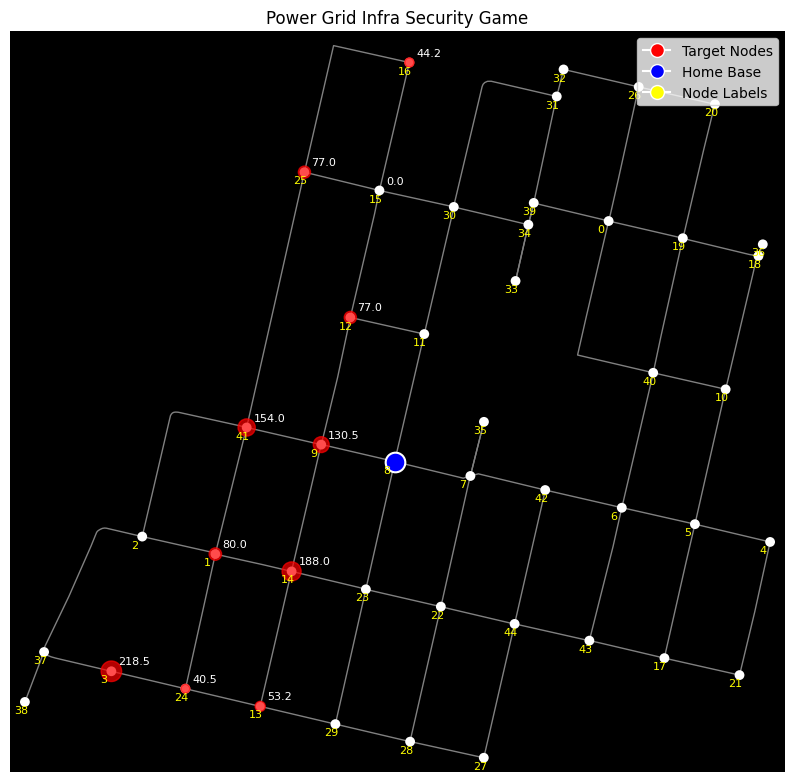

In [91]:
isg.draw_graph()

In [92]:
len(isg.attacker_strategies)

144

In [93]:
len(isg.defender_strategies)

29249

In [94]:
isg.attacker_strategies

array([[[16, 16],
        [16, 16],
        [16, 16],
        ...,
        [16, 16],
        [16, 16],
        [16, 16]],

       [[16, 25],
        [16, 25],
        [16, 25],
        ...,
        [16, 25],
        [16, 25],
        [16, 25]],

       [[16, 12],
        [16, 12],
        [16, 12],
        ...,
        [16, 12],
        [16, 12],
        [16, 12]],

       ...,

       [[None, 14],
        [None, 14],
        [None, 14],
        ...,
        [None, 14],
        [None, 14],
        [None, 14]],

       [[None, 13],
        [None, 13],
        [None, 13],
        ...,
        [None, 13],
        [None, 13],
        [None, 13]],

       [[None, None],
        [None, None],
        [None, None],
        ...,
        [None, None],
        [None, None],
        [None, None]]], dtype=object)

In [95]:
isg.defender_strategies

array([[[ 8],
        [23],
        [23],
        ...,
        [ 9],
        [ 9],
        [ 8]],

       [[ 8],
        [ 8],
        [23],
        ...,
        [41],
        [ 9],
        [ 8]],

       [[ 8],
        [ 8],
        [ 8],
        ...,
        [ 8],
        [ 8],
        [ 8]],

       ...,

       [[ 8],
        [23],
        [14],
        ...,
        [ 8],
        [ 8],
        [ 8]],

       [[ 8],
        [ 8],
        [ 8],
        ...,
        [41],
        [ 9],
        [ 8]],

       [[ 8],
        [ 8],
        [23],
        ...,
        [41],
        [ 9],
        [ 8]]])

In [96]:
isg.utility_matrix

array([[ -44.25, -121.25, -121.25, ..., -188.  ,  -53.25,    0.  ],
       [ -44.25, -121.25, -121.25, ...,    0.  ,  -53.25,    0.  ],
       [ -44.25, -121.25, -121.25, ..., -188.  ,  -53.25,    0.  ],
       ...,
       [ -44.25, -121.25, -121.25, ..., -188.  ,  -53.25,    0.  ],
       [ -44.25, -121.25, -121.25, ...,    0.  ,  -53.25,    0.  ],
       [ -44.25,  -44.25, -121.25, ...,    0.  ,  -53.25,    0.  ]])